In [39]:
from rocketcea.cea_obj_w_units import CEA_Obj
from proptools import nozzle  
import time
import numpy as np  
######
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

import joblib
import json

from tqdm import tqdm


## Intervalo de operação dos atributos

- P_c (Pressure Chamber): 1e6 a 30e6;
- MR (Mixture Ratio): 1 a 9;
- eps (Expansion Ratio): 2 a 200.

In [40]:
class CompareTime():
    """
    Classe que realizará a comparação do tempo de execução do CEA e dos modelos de regressão
    """

    def __init__(self, model_path=False, n_inds=10000, n_measures=10, model_name='linear_regression' ):
        # Caso model_path for uma string, carrega o modelo de regressão (sklearn)
        if isinstance(model_path, str):
            self.model = joblib.load(model_path)

        # Inicializa a seed do numpy
        np.random.seed(0)

        # Carrega o caminho do modelo de regressão
        self.model_path = model_path
        
        # Carrega o número de individuos para realizar a comparação
        self.n_inds = n_inds

        # Carrega o número de medidas para realizar a comparação
        self.n_measures = n_measures

        # Carrega o nome do modelo
        self.model_name = model_name

        # Gera um vetor aleatório com valores variando de 0 a 1 com 3 dimensões
        self.X = np.random.rand(self.n_inds, 3)
        self.X = np.expand_dims(self.X, axis=1)

        # Caso o model Path for falso, carrega o CEA
        oxName = 'LOX'
        fuelName = 'RP-1'
        self.ceaObj = CEA_Obj( oxName=oxName, fuelName=fuelName, pressure_units='MPa', cstar_units='m/s', temperature_units='K')
        if not model_path:
            self.model = self.ceaObj
            # Denormaliza o vetor aleatório para os valores de entrada do CEA
            # P_C 1e6 a 30e6 Pa
            # MR 1 a 9
            # eps 2 a 200
            self.X[:,:,0] = self.X[:,:,0]*29e6 + 1e6
            self.X[:,:,1] = self.X[:,:,1]*8 + 1
            self.X[:,:,2] = self.X[:,:,2]*198 + 2

    def measure_time(self):
        # Faz a medida de tempo de predição sequencial do modelo de regressão sobre o vetor aleatório
        start = time.time()
        if self.model_path:
            for i in range(self.n_inds):
                self.model.predict(self.X[i])
        else:
            for i in range(self.n_inds):
                IspVac, Cstar, Tc, mw, gamma = self.model.get_IvacCstrTc_ChmMwGam(Pc=self.X[i][0][0], MR=self.X[i][0][1], eps=self.X[i][0][2])
        end = time.time()
        self.regression_time = end - start

    def boxplot(self):
        # Chama a função que realiza a medição de tempo self.n_measures vezes e salva os reesultados em um diciionário
        # para gerar posteriormente um boxplot

        # Dicionário que armazenará os resultados
        results = {}
        
        # Realiza a medição de tempo self.n_measures vezes
        for i in tqdm(range(self.n_measures)):
            self.measure_time()
            results[i] = self.regression_time

        # Salva os resultados em um dicionário contendo o nome do modelo e os tempos de execução
        #
        results = {'model_name': self.model_name, 'times': results}

        self.results = results    

        # Salva em um json dentor da pasta ./times
        with open('./times/'+self.model_name+'.json', 'w') as fp:
            json.dump(results, fp)

        return




# CEA Original

In [41]:
model_path = False
model_name = "CEA"
n_inds = 10000
n_measures = 10

compare_time = CompareTime(model_path=model_path, n_inds=n_inds, n_measures=n_measures, model_name=model_name)
compare_time.boxplot()

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:35<00:00,  3.59s/it]


# Regressão Linear

In [42]:
model_path = '/home/ubuntu/Mestrado/modelo_foguete/improve_exec_speed/data/LinearRegression_score_0.41.joblib'
model_name = 'linear_regression'
n_inds = 10000
n_measures = 10

compare_time = CompareTime(model_path=model_path, n_inds=n_inds, n_measures=n_measures, model_name=model_name)
compare_time.boxplot()

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


# Árvore de Decisão

In [43]:
model_path = '/home/ubuntu/Mestrado/modelo_foguete/improve_exec_speed/data/DecisionTreeRegressor_score_1.0.joblib'
model_name = 'decision_tree_regressor'
n_inds = 10000
n_measures = 10

compare_time = CompareTime(model_path=model_path, n_inds=n_inds, n_measures=n_measures, model_name=model_name)
compare_time.boxplot()

100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


# MLP

In [44]:
model_path = '/home/ubuntu/Mestrado/modelo_foguete/improve_exec_speed/data/MLPRegressor_score_0.91.joblib'
model_name = 'mlp_regressor'
n_inds = 10000
n_measures = 10

compare_time = CompareTime(model_path=model_path, n_inds=n_inds, n_measures=n_measures, model_name=model_name)
compare_time.boxplot()

100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


# Gerando o boxplot

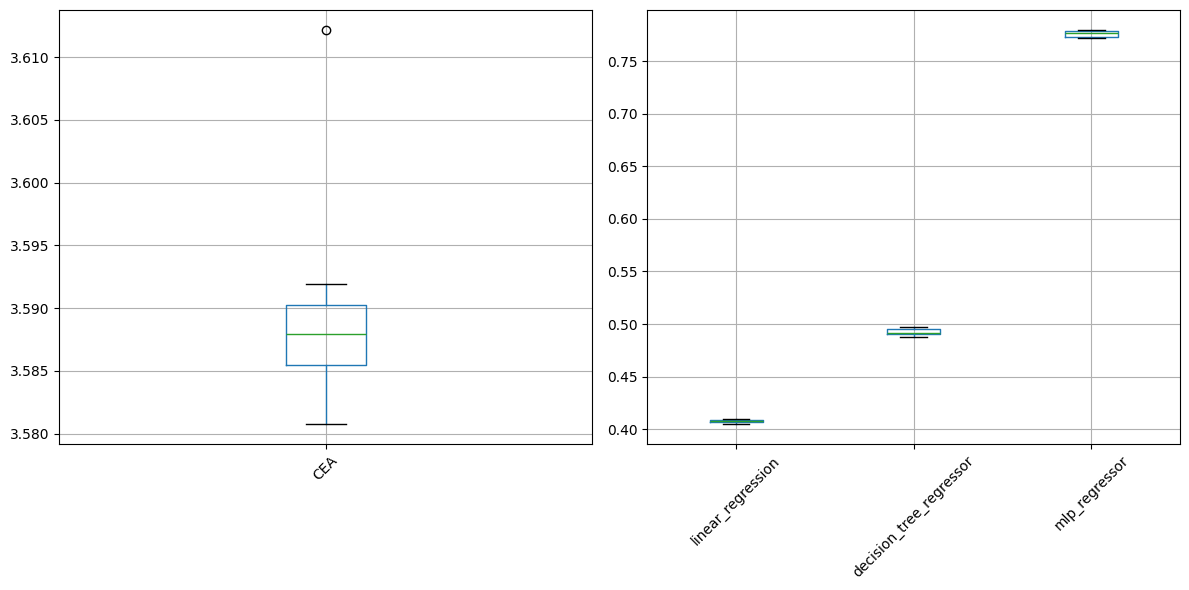

CEA                        3.589444
linear_regression          0.407575
decision_tree_regressor    0.492393
mlp_regressor              0.775945
dtype: float64
CEA                        3.589444
linear_regression          0.407575
decision_tree_regressor    0.492393
mlp_regressor              0.775945
dtype: float64


In [53]:
# Lê todos os arquivos json dentro da pasta ./times e gera um boxplot de execução, comparando os modelos. Dizendo qual o nome do modelo e o tempo de execução

import matplotlib.pyplot as plt
import json
import os
import pandas as pd

# Lista todos os arquivos dentro da pasta ./times
files = os.listdir('./times')

# Dicionário que armazenará os resultados
results = {}

# Para cada arquivo dentro da pasta ./times
for file in files:
    # Abre o arquivo
    with open('./times/'+file, 'r') as fp:
        # Carrega o arquivo
        data = json.load(fp)
        # Armazena o nome do modelo e os tempos de execução
        results[data['model_name']] = data['times']

# Transforma o dicionário em um dataframe
df = pd.DataFrame.from_dict(results)

# Gera dois boxplots lado a lado. Um contendo apenas o CEA e o outro o restnatee dos modelos. Isso é feito para não afetar a escala de visualização dos tempos de execução
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
df[['CEA']].boxplot(ax=ax1)
df.drop('CEA', axis=1).boxplot(ax=ax2)

# Rotate x-axis labels
ax1.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print the mean execution time of each model
print(df.mean())
print(df.mean())



# Plotando gráficos analisando a qualidade de predição

In [54]:
from sklearn.model_selection import train_test_split

data_path = '/home/ubuntu/Mestrado/modelo_foguete/improve_exec_speed/data/grid_target.csv'

# Leitura dos dados
df_grid_target = pd.read_csv(data_path)

# Processa e converte para numpy
X_y = df_grid_target.to_numpy()
X = X_y[:,0:3]
y = X_y[:,3:]

# Deleta o dataframe para liberar espaco na RAM
del df_grid_target

# Divide os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [56]:
model = joblib.load('/home/ubuntu/Mestrado/modelo_foguete/improve_exec_speed/data/DecisionTreeRegressor_score_1.0.joblib')

pred = model.predict(X_test)

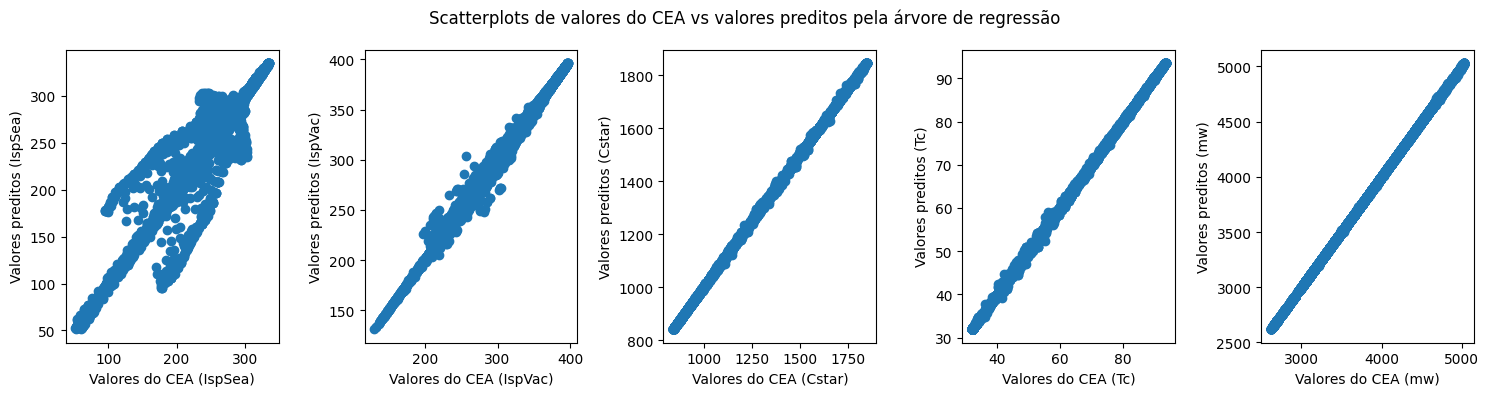

In [62]:
# Número de subplots

num_plots = 5

# Configuração da figura
fig, axes = plt.subplots(1, num_plots, figsize=(15, 4))  # 1 linha e 'num_plots' colunas de subplots.

# Título geral
fig.suptitle("Scatterplots de valores do CEA vs valores preditos pela árvore de regressão")

nomes_predicoes = ['IspSea', 'IspVac', 'Cstar', 'Tc', 'mw', 'gamma']

# Loop para criar os subplots
for i in range(num_plots):
    if nomes_predicoes == 'Cstar':
        # caso seja Cstar, não plota nada
        continue
    ax = axes[i]
    ax.scatter(y_test[:, i], pred[:, i])
    ax.set_xlabel(f"Valores do CEA ({nomes_predicoes[i]})")
    ax.set_ylabel(f"Valores preditos ({nomes_predicoes[i]})")

plt.tight_layout()
plt.show()